In [32]:
import snntorch as snn
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [3]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

In [4]:
data_path = '.'

In [5]:
mnist_train = datasets.MNIST(data_path, train=True,
                             download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False,
                            download=True, transform=transform)

100.0%
100.0%
100.0%
100.0%


In [27]:
mnist_train[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [29]:
mnist_train[0][0].shape, mnist_train[0][0].squeeze(0).shape, mnist_train[0][0][0].shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]), torch.Size([28, 28]))

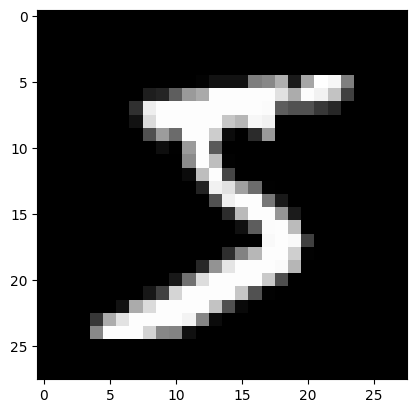

In [31]:
import matplotlib.pyplot as plt 

plt.imshow(mnist_train[0][0].squeeze(), cmap='gray')

In [64]:
batch_size = 64

In [65]:
60000 / 64

937.5

In [67]:
train_loader = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size,
                         shuffle=True, drop_last=True)

In [68]:
len(train_loader)

937

In [77]:
for x,y in train_loader:
    break

In [80]:
x.view(batch_size, -1).shape

torch.Size([64, 784])

tensor(2)


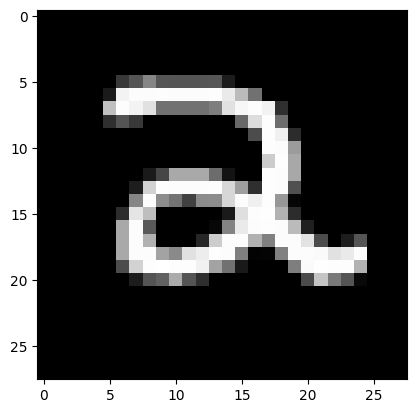

In [45]:
plt.imshow(x[12].squeeze(), cmap='gray')
print(y[12])

In [ ]:
# Definizione della classe Model
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Inizializziamo l'architettura della SNN
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Inizializzazione delle variabili di stato
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Lista per i valori finali
        spk2_rec = []
        mem2_rec = []
        spk1_rec = []
        # Elaborazione dell'input per tutta l'architettura
        # della rete e per tutti i timesteps
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_rec.append(spk1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), torch.stack(spk1_rec, dim=0)

# Load the network onto CUDA if available
model = Model()

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [ ]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Definizione del traninig loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Training per batch
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        spk_rec, mem_rec = model(data.view(batch_size, -1))

        # Inizializzazione della loss e somma per i timestep
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Calcolo del gradiente e aggiornamento dei pesi
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
